In [23]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] =(12,9)
import os
import copy
from IPython.display import clear_output
import torch
from torchvision import transforms
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.utils.data import DataLoader,Subset
from torch.autograd import Variable
import PIL
import torch.optim as optim
import compression as comp

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# define the dataloader and load the data 

In [31]:
# initialize the dataloader and normalize the data 
class Dataset:
    """load the image / encoded object position representation pairs for training and testing data"""
    def __init__(self, path, mode = 'train'):
        self.path=path
        self.mode=mode
    def __getitem__(self, index):
        mode = self.mode
        if mode=='train':
            fname = '/train-%05d.jpg'
        elif mode=='test':
            fname = '/test-%05d.jpg'
            
        if mode=='train':
            fname1 = 'train-comp-%05d.npy'
        elif mode=='test':
            fname1 = 'test-comp-%05d.npy'
        img = PIL.Image.open(self.path+fname%index)
        vect = np.load(self.path+fname1%index)
        transform = transforms.Compose([#transforms.Scale((227,227)),
                                        transforms.ToTensor(),
                                        #transforms.Normalize(mean=[0.5],std=[0.25])
                                       ])
        img = transform(img)
        if mode=='train':
            img.requires_grad=True
        vect = torch.FloatTensor(np.concatenate(vect)) 
        return img, vect 

    def __len__(self):
        return len([f for f in os.listdir(self.path) if f.endswith('.jpg')])

# Initialize dataset iterators and find gpu if available 
train_data = Dataset('./data/training/',mode='train')
test_data = Dataset('./data/testing/',mode='test')
print('data is loaded')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device is '+ str(device))

data is loaded
device is cuda:0


# define the cnn

In [32]:
class Net(nn.Module):
    """ this is lenet adapted to the problem """
    def __init__(self):
        super(Net, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 6, 7, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), 2),
            nn.Conv2d(6, 16, 5, 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), 2),
            nn.Conv2d(16, 120, 5, 1),
            nn.ReLU(inplace=True)
                                    )
        self.fc = nn.Sequential(
            #nn.Dropout(),
            nn.Linear(120*13**2, 5000),
            nn.ReLU(),
            #nn.Dropout(),
            nn.Linear(5000, 500),
                                )
    def forward(self, img):
        output = self.convnet(img)
        output = output.view(-1, 120*13**2)
        output = self.fc(output)
        return output

# train the network 

In [33]:
model = Net().to(device).train()

In [ ]:
# initialize the model 
#model = Net().to(device).train()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True)
train_losses = []
val_losses = []
min_val_loss = 999999.9 # for early stopping 

# set up the training loop and dataset iterator 
k = 100 #size of batch 
N = 1000 #number epochs
b = int(len(train_data)/k) #number of batches
train_loader = DataLoader(train_data , batch_size = k, shuffle = True) #batch data loader
test_loader = DataLoader(test_data, batch_size = k, shuffle = False)
val_data = next(iter(test_loader))

# train the network N epochs through the dataset 
for epoch in range(N): # epoch iterator 
    epoch_loss = 0 # mean loss per epoch 
    # minibatch training 
    for i, (inputs, targets) in enumerate(train_loader): # batch iterator 
        inputs, targets = inputs.to(device), targets.to(device) # batch to gpu
        optimizer.zero_grad() # zero gradients
        outputs = model(inputs) # model prediction
        loss = criterion(outputs, targets)  # loss computation
        loss.backward() # backpropagation
        optimizer.step() # gradient descent 
        epoch_loss+=loss.cpu().data.item() # pull the batch losses 
    epoch_loss /= i
    print('epoch ', epoch, ' training loss: ',round(epoch_loss,2)) # print epoch loss
    train_losses.append(epoch_loss)
    scheduler.step(epoch_loss) # possibly modify the learning rate 
    
    if epoch%5==0:  # early stopping 
        # calculate the validation loss over a batch 
        inputs, targets = val_data
        inputs, targets = inputs.to(device), targets.to(device) # batch to gpu
        outputs = model(inputs) # model prediction
        loss = criterion(outputs, targets)
        val_loss = loss.cpu().data.item()
        val_losses.append(val_loss)
        if val_loss < min_val_loss:
            min_val_loss = val_loss 
            torch.save(model.state_dict(),'earlystop.pt') # save partially trained model 
            print('model saved (early stop). ', 'validation loss was ', min_val_loss)
        else:
            print('model not saved. validation loss was ', val_loss)

epoch  0  training loss:  43340.2
model saved (early stop).  validation loss was  14039.9296875
epoch  1  training loss:  9300.2
epoch  2  training loss:  8512.22
epoch  3  training loss:  8099.24


Text(0,0.5,'loss')

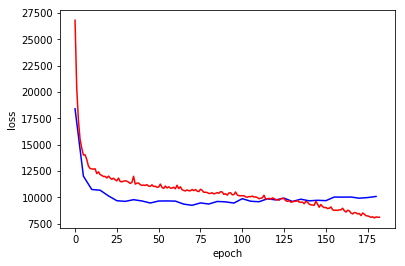

In [22]:
plt.plot(range(0,5*len(val_losses),5),val_losses,color='blue')
plt.plot(range(len(train_losses)),train_losses,color='red')
plt.xlabel('epoch')
plt.ylabel('loss')

# diagnose output by decompression / visualization 

In [ ]:
model.state_dict() = torch.load('trained.pt')
model.eval()

In [ ]:
test_loader = DataLoader(test_data , batch_size = k, shuffle = True) #batch data loader
for i,(x,y) in enumerate(test_loader):
    break
y_ = model(x.to(device)).cpu().detach().numpy()
y = y.numpy()

In [ ]:
for n in range(3):
    plt.plot(y[n],'x')
    plt.plot(y_[n],'o')
    plt.show()

In [ ]:
S = np.load('./data/sensing_matrix.npy')
shape = x[0].numpy().shape[1:]
_,M = shape
N = 100
L = 5

In [ ]:
Y = y_[0]
Y = Y.reshape(L,N)

In [ ]:
pts = comp.unproject(F,shape,5,M)

In [ ]:
im = x[0].numpy().squeeze()
for p in pts:
    im = comp.draw_plus(p,im)
plt.imshow(im,cmap='gray')

In [ ]:
mask = (pts.T[0]>0)&(pts.T[0]<150)&(pts.T[1]>0)&(pts.T[1]<150)
np.where(mask)